# Prize-Collecting Steiner Tree (PCSTP)

## Libs Importing

In [1]:
import sys
import os
import time
import networkx as nx
from typing import Tuple, Set

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
from pcstp.instances.generator import generate_random_steiner
from pcstp.utils.draw import draw_steiner_graph

## Experiments

In [3]:
G, (nodes, edges, position_matrix, edges_cost, terminals, prizes) = generate_random_steiner(
    num_nodes=25,
    num_edges=20,
    max_node_degree=10,
    min_prize=0,
    max_prize=100,
    num_terminals=5,
    min_edge_cost=0,
    max_edge_cost=10,
    cost_as_length=False,
    max_iter=100,
    seed=11
)

terminals:  (5,)
prizes:  (5,)


In [4]:
from pcstp.steinertree import SteinerTreeProblem
from pcstp.instances.reader import SteinlibReader, DatReader
from pcstp.solver.base import computes_steiner_cost

The instance can be imported from a file or generated through the instance generator presented above.

In [5]:
stp = SteinerTreeProblem(graph=G, terminals=terminals)

In [6]:
from pcstp.solver.base import computes_steiner_cost

In [7]:
from pcstp.utils.graph import preprocessing

In [8]:
stp_reader = SteinlibReader()
stp = stp_reader.parser(filename='../data/instances/stp/C01-A.stp')

In [9]:
print("Nodes: ", len(stp.graph.nodes))
print("Edges: ", len(stp.graph.edges))

Nodes:  500
Edges:  625


In [10]:
G, terminals = preprocessing(stp.graph, stp.terminals)

Iteration: 1 - Removing nodes: [294, 458, 327, 368, 402, 382, 410, 109, 107, 330, 434, 60, 210, 151, 289, 40, 91, 403, 474, 227, 404, 201, 64, 65, 299, 360, 264, 459, 154, 216, 110, 430, 488, 50, 471, 12, 477, 118, 78, 63, 308, 188, 408, 37, 448, 239, 377, 433, 191, 311, 268, 261, 320, 371, 53, 455, 8, 466, 362, 394, 300, 316, 102, 49, 399, 325, 469, 262, 345, 211, 117, 415, 461, 140, 7, 483, 265, 225, 484, 228, 290, 108, 339, 428, 15, 100, 447, 5, 353, 199, 25, 130, 442, 66, 203, 475, 75, 185, 165, 314, 219, 490, 367, 391, 427, 36, 215, 212, 251, 260, 285, 281, 350, 332, 181, 28, 180, 352, 450, 344, 213, 298, 76, 286, 296, 321, 24, 326, 187, 195, 492, 74, 80, 233, 336, 301, 256, 366, 18, 47, 274, 303, 291]
Iteration: 2 - Removing nodes: [282, 462, 424, 146, 149, 378, 409, 287, 413, 182, 340, 232, 189, 234, 248, 275, 193, 436, 324, 156, 133, 331, 145, 445, 115, 255, 92, 217, 472, 62, 356, 106, 498, 220]
Iteration: 3 - Removing nodes: [148, 113, 162, 124, 26, 467, 429, 95, 22, 273, 94]


In [11]:
stp_preprocessed = SteinerTreeProblem(graph=G, terminals=terminals)

In [12]:
print("Nodes: ", len(stp_preprocessed.graph.nodes))
print("Edges: ", len(stp_preprocessed.graph.edges))

Nodes:  311
Edges:  436


## Solution obtained with NetworkX Steiner Tree Approximation Algorithm

In [13]:
# %%timeit -n 100

start_time = time.time()

nx_steiner_tree = nx.algorithms.approximation.steinertree.steiner_tree(
    stp_preprocessed.graph,
    stp_preprocessed.terminals,
    weight='cost'
)

networkx_duration = time.time() - start_time
networkx_cost = computes_steiner_cost(G, nx_steiner_tree, terminals)
print(f'Cost: {networkx_cost}')


Cost: 88


In [14]:
print(f'Duration: {networkx_duration*1000} ms')

Duration: 277.8956890106201 ms


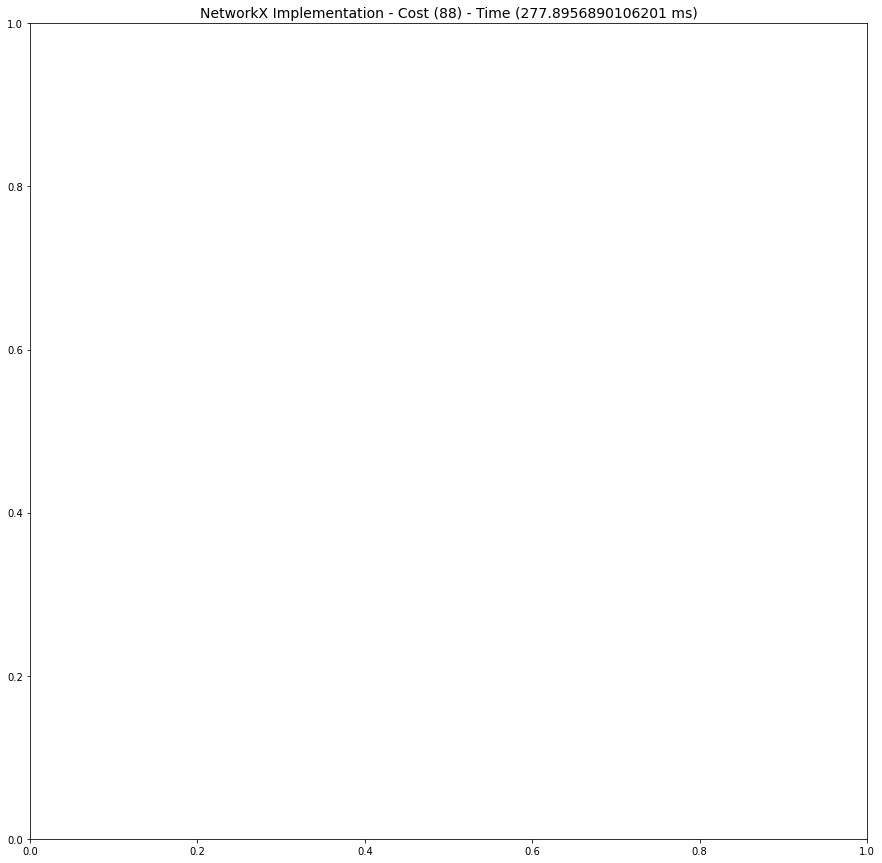

In [15]:
try:
    draw_steiner_graph(
        stp_preprocessed.graph,
        steiner_graph=nx_steiner_tree,
        plot_title=f'NetworkX Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
        node_label='name'
    )
except:
    pass


## Solution obtained with Ant Colony Optimization

In [16]:
from pcstp.solver.aco import AntColony

In [24]:
# %%timeit -n 100

solver = AntColony(
    graph=stp_preprocessed.graph,
    terminals=stp_preprocessed.terminals,
    iterations=100,
    num_ants=1,
    evaporation_rate=0.2,
    alpha=1.0,
    beta=1,
    beta_evaporation_rate=0.4,
    initial_pheromone=0.1,
    pheromone_amount=1,
    pheromone_initialization_strategy='same_value',
    choose_best=0.3,
    log_level='info',
    early_stopping=None
)
steiner_tree, steirner_cost = solver.solve()


2022-01-26 10:03:48,591 - [aco.py:235] - INFO - Best Iteration: 5 - Best Cost: 257


In [18]:
print(f'Cost: {steirner_cost}')

Cost: 620


In [19]:
print(f'Duration: {solver._duration * 1000} ms')

Duration: 36.661386489868164 ms


In [20]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Steiner Cost')

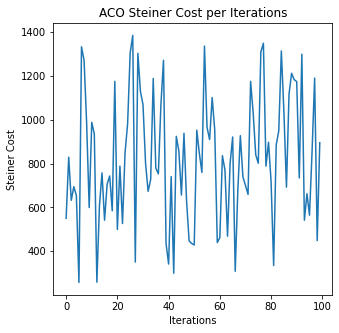

In [25]:

fig, ax = plt.subplots(1, 1,figsize=(5,5))

ax.plot(solver.history)
ax.set_title("ACO Steiner Cost per Iterations")
ax.set_xlabel("Iterations")
ax.set_ylabel("Steiner Cost")

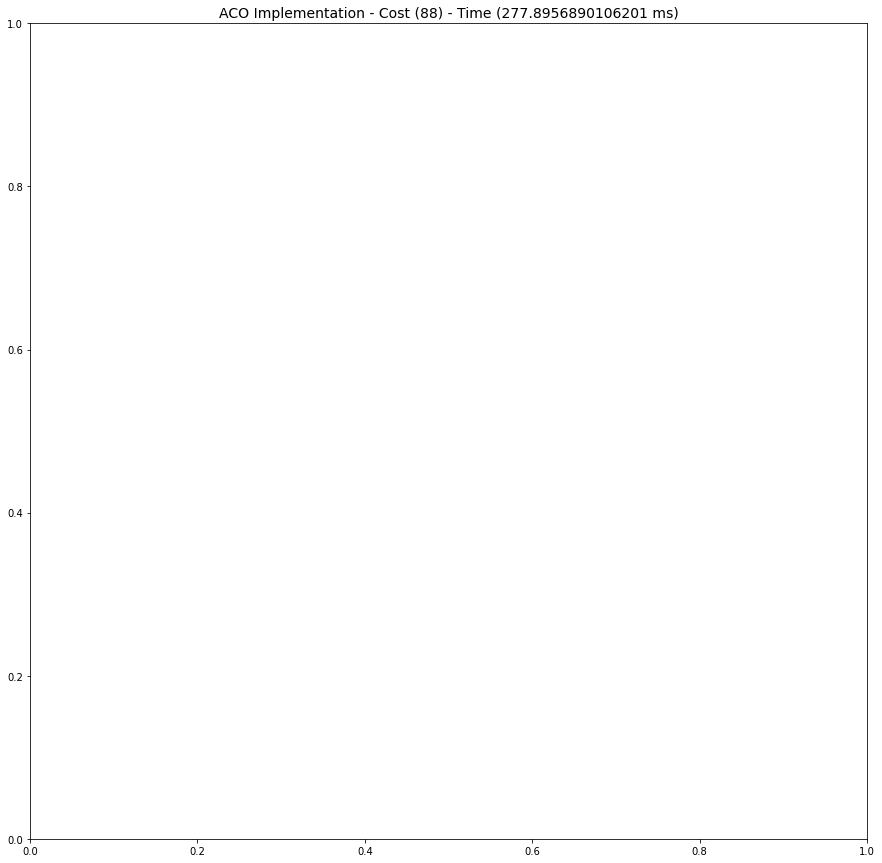

In [22]:
try:
    draw_steiner_graph(
        stp_preprocessed.graph,
        steiner_graph=steiner_tree,
        plot_title=f'ACO Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
        node_label='name'
    )
except:
    pass


In [23]:
steiner_tree.nodes

NodeView((128, 127, 278, 267, 375, 319, 454, 414, 246, 129, 150, 88, 460, 119, 57, 120, 499, 164, 19, 363, 449, 77, 370, 177, 105, 307, 143, 355, 242, 341, 3, 380, 494, 372, 223, 373, 51, 209, 32, 167, 214, 426, 284, 190, 374, 13, 468, 39, 411, 486, 457, 334, 485, 479, 390, 172, 70, 112, 4, 48, 349, 41, 147, 323, 90, 20, 401, 241, 142, 376, 297, 465, 315, 33, 166, 46, 205, 310, 389, 252, 456, 393, 309, 144, 6, 202, 354, 152, 222, 59, 280, 52, 244, 226, 96, 343, 174, 243, 396, 359, 38, 407, 495, 134, 322, 441, 277, 72, 179, 276, 269, 412, 123, 207, 338, 173, 21, 153, 249, 161, 125, 386, 392, 200, 245, 406, 206, 236, 397, 30, 398, 155, 139))